In [1]:
import os

#is the notebook running on Colab?
if 'COLAB_JUPYTER_TRANSPORT' in os.environ.keys():
    isColab = True
    sourcedir =os.getcwd()+ "/CPlantBox"
    filedir = sourcedir +"/tutorial/jupyter/fspm_2023"
else:
    isColab = False
    sourcedir = os.getcwd()+"/../../.."
    filedir = os.getcwd()
#this can take some minutes
if isColab:
    # downloading the source code
    ! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox --depth=1 --single-branch -b stable_v2.1
    os.chdir(sourcedir)
    !apt install libeigen3-dev
    ! apt install llvm-dev
    !pip3 install vtk
    !sudo DEBIAN_FRONTEND=noninteractive apt-get install -yq xvfb
    !pip install -q 'xvfbwrapper~=0.2.9'
    if 'vdisplay' not in globals():
        # start a virtual X display for MAGICAL rendering
        import xvfbwrapper
        vdisplay = xvfbwrapper.Xvfb()
        vdisplay.start()
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"


    if os.path.exists("./src/external/pybind11"):
        ! rm -rf src/external/pybind11 #delete folder
    ! git rm -r --cached src/external/pybind11 #take out git cache for pybind11
    ! git submodule add --force -b stable https://github.com/pybind/pybind11.git ./src/external/pybind11


    ! git pull
    ! cmake .
    ! make
    os.chdir(filedir)

# Coupled carbon and water flow in CPlantBox

## Simulation of water and carbon movement 


In the following we will show how to compute the coupled water and carbon flow in the plant. 



We consider a dynamic plant and a static soil. 
To compute the carbon flux, we use the code developped by Lacointe et al. (2019).

**Reference**

A Lacointe and P. Minchin. A mechanistic model to predict distribution of carbon among multiple sinks. *Methods in molecular biology* (Clifton, N.J.) vol. 2014, 2019.
	

The sucrose flow depends on several plant, soil and atmospheric variables. For clarity, the basic functions defining those variables were moved to the file "parametersSucroseFlow".

In [2]:
import sys; sys.path.append(sourcedir); sys.path.append(sourcedir+"/src")
sys.path.append(sourcedir+"/modelparameter/functional")
import plantbox as pb
from functional.xylem_flux import XylemFluxPython  # Python hybrid solver
import numpy as np
import visualisation.vtk_plot as vp # for quick 3d vizualisations
import matplotlib.pyplot as plt
from functional.phloem_flux import PhloemFluxPython  
from plant_photosynthesis.wheat_FcVB_Giraud2023adapted import *
from plant_hydraulics.wheat_Giraud2023adapted import *
from plant_sucrose.wheat_phloem_Giraud2023adapted import *
from climate.dummyWeather import *
import numpy as np

## 1. Define initial conditions

In [3]:

#we start with a small plant to have a lower computation time
simInit = 7 # [day] init simtime
simMax = 8
dt =2/24
depth = 60
weatherInit = weather(simInit)
simDuration = simInit


# plant system 
pl = pb.MappedPlant(seednum = 2) #seednum: gives the option of setting a random seed to make the simulations replicable
path = "../../../modelparameter/structural/plant/"
name = "Triticum_aestivum_adapted_2023"
pl.readParameters(path + name + ".xml")

sdf = pb.SDF_PlantBox(np.Inf, np.Inf, depth )
pl.setGeometry(sdf) # creates soil space to stop roots from growing out of the soil


verbose = False
pl.initialize(verbose )
pl.simulate(simInit, verbose)


#for post-processing
Q_out = 0 #sucrose lost by the plant
AnSum = 0 #assimilation
filename = "phloemoutputs.txt" 

Q_Rmbu      = np.array([0.])
Q_Grbu      = np.array([0.])
Q_Exudbu    = np.array([0.])
Q_STbu    = np.array([0.])

Q_Rmall      = np.array([])
Q_Grall      = np.array([])
Q_Exudall    = np.array([])
lengthTotall    = np.array([])
time = np.array([])
lengthTotInit = sum(pl.segLength())
lengthTotBU = sum(pl.segLength())

OrganRandomParameter::readXML: warning! parameter delayLat is defined in the xml, but not available in organ stem
MappedPlant::initialize 


## 2. Define static soil

In [4]:

min_b = [-3./2, -12./2, -61.]#distance between wheat plants
max_b = [3./2, 12./2, 0.]
cell_number = [6, 24, 61] #soil resolution
layers = depth; soilvolume = (depth / layers) * 3 * 12
k_soil = [] #conductivity of soil when in contact with roots
p_mean = weatherInit['p_mean'] #mean soil water potential
p_bot = p_mean + depth/2
p_top = p_mean - depth/2
sx = np.linspace(p_top, p_bot, depth) #soil water potential per voxel

picker = lambda x,y,z : max(int(np.floor(-z)),-1) 
pl.setSoilGrid(picker)  # maps segment


## 3. create object to compute carbon and water flux
The PhloemFluxPython class containes the functionalities of PhotosynthesisPython as well as the sucrose-related functions.

In [5]:
#give initial guess of leaf water potential and internal CO2 partial pressure (to start computation loop)
r = PhloemFluxPython(pl,psiXylInit = min(sx),ciInit = weatherInit["cs"]*0.5)


## 4. set other parameters and initial variable
We present bellow some of the main sucrose-related parameters.

In [6]:
r = setPhotosynthesisParameters(r,weatherInit)

r = setKrKx_phloem(r) # conductivity of the sieve tube
r.setKrm2([[2e-5]]) #effect of the sucrose content on maintenance respiration 
r.setKrm1([[10e-2]]) #effect of structural sucrose content on maintenance respiration
r.setRhoSucrose([[0.51],[0.65],[0.56]])  #sucrose density per organ type (mmol/cm3)
r.setRmax_st([[14.4,9.0,6.0,14.4],[5.,5.],[15.]]) #maximum growth rate when water and carbon limitation is activated
r.KMfu = 0.11                                     #michaelis menten coefficient for usage of sucrose
r.beta_loading = 0.6 #feedback effect of sieve tube concentraiton on loading from mesophyll
r.Vmaxloading = 0.05 #mmol/d, max loading rate from mesophyll
r.Mloading = 0.2                                      #michaelis menten coefficient for loading of sucrose
r.Gr_Y = 0.8 # efficiency of sucrose usage for growth. if <1, we have growth respiration
r.CSTimin = 0.4 #minimum sucrose concentration below which no sucrose usage occures
r.Csoil = 1e-4 #mean soil concentration in sucrose


r.update_viscosity = True #update sucrose viscosity according to concentraiton ?
r.atol = 1e-12 #max absolute error for sucrose flow solver
r.rtol = 1e-8 #max relative error for sucrose flow solver


Exchange zone in roots: kr_st > 0 until -1cm from root tip 0 0


## 5. launch simulation
In this simulation, we use the same time step for all the modules. The first time steps tend to require longer computation time. increasing the maximum errors allowed for the sucrose computation (r.atol, r.rtol) and the minium and maximum plant segment length (dxMin, dx) can help decrease the computaiton time.

In [7]:

while simDuration <= simMax: 
    
    Nt = len(r.plant.nodes) 
    weatherX = weather(simDuration) #update weather variables
    r.Qlight = weatherX["Qlight"] #
    r = setKrKx_xylem(weatherX["TairC"], weatherX["RH"], r) #update xylem conductivity data
    
    #compute plant water flow
    r.solve_photosynthesis(ea_=weatherX["ea"], es_ = weatherX["es"], 
                           sim_time_ = simDuration, sxx_=sx, cells_ = True,
                           verbose_ = False, doLog_ = False,TairC_= weatherX["TairC"] )
    
    
    AnSum += np.sum(r.Ag4Phloem)*dt #total cumulative carbon assimilaiton
    errLeuning = sum(r.outputFlux) #should be 0 : no storage of water in the plant
    fluxes = np.array(r.outputFlux)
    fluxesSoil = r.soilFluxes(simDuration, r.psiXyl, sx, approx=False) #root water flux per soil voxel
    
    
    #simulation of phloem flow
    startphloem= simDuration
    endphloem = startphloem + dt
    stepphloem = 1
    r.startPM(startphloem, endphloem, stepphloem, ( weatherX["TairC"]  +273.15) , True, filename)
        
    #get ouput of sucrose flow computation    
    Q_ST    = np.array(r.Q_out[0:Nt])          #sieve tube sucrose content
    Q_meso  = np.array(r.Q_out[Nt:(Nt*2)])     #mesophyll sucrose content
    Q_Rm    = np.array(r.Q_out[(Nt*2):(Nt*3)]) #sucrose used for maintenance respiration
    Q_Exud  = np.array(r.Q_out[(Nt*3):(Nt*4)]) #sucrose used for exudation
    Q_Gr    = np.array(r.Q_out[(Nt*4):(Nt*5)]) #sucrose used for growth and growth respiration
    
    C_ST    = np.array(r.C_ST)           #sieve tube sucrose concentraiton
    volST   = np.array(r.vol_ST)         #sieve tube volume
    volMeso   = np.array(r.vol_Meso)      #mesophyll volume     
    C_meso  = Q_meso/volMeso              #sucrose concentration in mesophyll
    Q_out   = Q_Rm + Q_Exud + Q_Gr       #total sucrose lost/used by the plant
    error   = sum(Q_ST + Q_meso + Q_out )- AnSum  #balance residual (error)
    
    lengthTot = sum(r.plant.segLength()) #total plant length 
    
    #variation of sucrose content at the last time step (mmol)
    Q_ST_i        = Q_ST      - Q_STbu #in the sieve tubes
    Q_Rm_i        = Q_Rm      - Q_Rmbu #for maintenance
    Q_Gr_i        = Q_Gr      - Q_Grbu #for growth
    Q_Exud_i      = Q_Exud    - Q_Exudbu #for exudation
    Q_out_i       = Q_Rm_i    + Q_Exud_i      + Q_Gr_i #total usage
    
    #print some outputs
    print("\n\n\n\t\tat ", int(np.floor(simDuration)),"d", int((simDuration%1)*24),"h, PAR:",  round(r.Qlight *1e6),"mumol m-2 s-1")
    print("Error in sucrose balance:\n\tabs (mmol) {:5.2e}\trel (-) {:5.2e}".format(error, div0f(error,AnSum, 1.)))
    print("Error in water balance:\n\tabs (cm3/day) {:5.2e}".format(errLeuning))
    print("water fluxes (cm3/day):\n\ttranspiration {:5.2e}".format(sum(fluxesSoil.values())))
    print("assimilated sucrose (cm)\tAn {:5.2e}".format(AnSum)) 
    print("sucrose concentration in sieve tube (mmol ml-1):\n\tmean {:.2e}\tmin  {:5.2e} at {:d} segs \tmax  {:5.2e}".format(np.mean(C_ST), min(C_ST), len(np.where(C_ST == min(C_ST) )[0]), max(C_ST)))        
    print('cumulated \tRm   {:.2e}\tGr   {:.2e}\tExud {:5.2e}'.format(sum(Q_Rm), sum(Q_Gr), sum(Q_Exud)))
    print("aggregated sink repartition at last time step (%) :\n\tRm   {:5.1f}\tGr   {:5.1f}\tExud {:5.1f}".format(sum(Q_Rm_i)/sum(Q_out_i)*100, 
         sum(Q_Gr_i)/sum(Q_out_i)*100,sum(Q_Exud_i)/sum(Q_out_i)*100))
    print("total aggregated sink repartition (%) :\n\tRm   {:5.1f}\tGr   {:5.1f}\tExud {:5.1f}".format(sum(Q_Rm)/sum(Q_out)*100, 
         sum(Q_Gr)/sum(Q_out)*100,sum(Q_Exud)/sum(Q_out)*100))
    print("growth rate (cm/day)\ttotal {:5.2e}\tlast time step {:5.2e}".format(lengthTot - lengthTotInit, lengthTot - lengthTotBU))      
    
    #plant growth based on Gr * Gr_Y
    r.plant.simulate(dt, verbose)
    simDuration += dt
    
    #for post processing
    Ntbu = Nt
    Nt = len(r.plant.nodes)
    lengthTotBU = lengthTot
    Q_STbu       =   np.concatenate((Q_ST, np.full(Nt - Ntbu, 0.)))
    Q_Rmbu       =   np.concatenate((Q_Rm, np.full(Nt - Ntbu, 0.)))
    Q_Grbu       =   np.concatenate((Q_Gr, np.full(Nt - Ntbu, 0.))) 
    Q_Exudbu     =   np.concatenate((Q_Exud, np.full(Nt - Ntbu, 0.))) 
    
    
    Q_Rmall    = np.append( Q_Rmall  ,sum(Q_Rm_i))
    Q_Grall    = np.append( Q_Grall  ,sum(Q_Gr_i))
    Q_Exudall  = np.append( Q_Exudall,sum(Q_Exud_i))
    lengthTotall  = np.append( lengthTotall,lengthTot)
    time       = np.append( time ,simDuration)
    


Kr_st is constant per subtype of organ type, for root, subtype 1 = 0.05 1 day-1 
Kx_st is constant per subtype of organ type, for root, subtype 1 = 1.32591e-13 cm3 day-1 
Across_st is constant per subtype of organ type, for root, subtype 1 = 9.62113e-06 cm2 
krm2 is constant 2e-05 -
krm1 is constant 0.1 -
rhoSucrose is constant per organ type, organ type 2 (root) = 0.51 mmol cm-3
Rmax_st is constant per subtype of organ type, for root, subtype 1 = 9 cm day-1 
Kr is constant per subtype of organ type, for root, subtype 0 = 6.49549e-05 1 day-1 
Kx is constant per subtype of organ type, for root, subtype 0 = 0.0678305 cm3 day-1 
Output times :
 7 7.08333
starting integration on time segment #1 = [7, 7.08333] 2 2



		at  7 d 0 h, PAR: 667 mumol m-2 s-1
Error in sucrose balance:
	abs (mmol) 1.40e-13	rel (-) 1.38e-12
Error in water balance:
	abs (cm3/day) -1.77e-11
water fluxes (cm3/day):
	transpiration -9.91e-01
assimilated sucrose (cm)	An 1.02e-01
sucrose concentration in sieve tube (mmol




		at  7 d 11 h, PAR: 667 mumol m-2 s-1
Error in sucrose balance:
	abs (mmol) 8.86e-14	rel (-) 1.12e-13
Error in water balance:
	abs (cm3/day) 1.04e-11at t = 7.5 : Y0.size() = 945
at 12:30:12 :  starting step n#1 (tf = 7.58333)
at t = 7.58333 : Y0.size() = 945

Final Statistics:
nst (num steps) = 5664   nfe  (num call to f)= 10417  nsetups (call to lin solver setup func)= 0     

nni (iter of nonlinear solver) = 10414  ncfn (non linsolver conv fail)= 2360   netf (num err test fail) = 0      nge (call to root function) = 0
 

at 12:30:12 :  exiting solver
MEMORY LIBERATIONS
fortran to python vector
computeOrgGrowth

water fluxes (cm3/day):
	transpiration -9.92e-01
assimilated sucrose (cm)	An 7.88e-01
sucrose concentration in sieve tube (mmol ml-1):
	mean 1.83e+00	min  1.68e+00 at 1 segs 	max  1.93e+00
cumulated 	Rm   9.16e-02	Gr   1.76e-02	Exud 3.98e-01
aggregated sink repartition at last time step (%) :
	Rm    14.9	Gr    12.9	Exud  72.2
total aggregated sink repartition (%) :
	Rm    

/tmp/ipykernel_1550/2142336765.py:57: RuntimeWarning: invalid value encountered in double_scalars
  print("aggregated sink repartition at last time step (%) :\n\tRm   {:5.1f}\tGr   {:5.1f}\tExud {:5.1f}".format(sum(Q_Rm_i)/sum(Q_out_i)*100,
/tmp/ipykernel_1550/2142336765.py:58: RuntimeWarning: invalid value encountered in double_scalars
  sum(Q_Gr_i)/sum(Q_out_i)*100,sum(Q_Exud_i)/sum(Q_out_i)*100))





		at Kr is constant per subtype of organ type, for root, subtype 0 = 6.49549e-05 1 day-1 
Kx is constant per subtype of organ type, for root, subtype 0 = 0.0678305 cm3 day-1 
Output times :
 8 8.08333
starting integration on time segment #1 = [8, 8.08333] 2 2
at t = 8 : Y0.size() = 1134
at 12:30:12 :  starting step n#1 (tf = 8.08333)
at t = 8.08333 : Y0.size() = 1134

Final Statistics:
nst (num steps) = 18648  nfe  (num call to f)= 35696  nsetups (call to lin solver setup func)= 0     

nni (iter of nonlinear solver) = 35693  ncfn (non linsolver conv fail)= 8448   netf (num err test fail) = 0      nge (call to root function) = 0
 

at 12:30:12 :  exiting solver
MEMORY LIBERATIONS
fortran to python vector
computeOrgGrowth
 7 d 23 h, PAR: 667 mumol m-2 s-1
Error in sucrose balance:
	abs (mmol) 1.70e-02	rel (-) 1.95e-02
Error in water balance:
	abs (cm3/day) 4.52e-12
water fluxes (cm3/day):
	transpiration -1.11e+00
assimilated sucrose (cm)	An 8.72e-01
sucrose concentration in sieve tub

## 8. plot some results

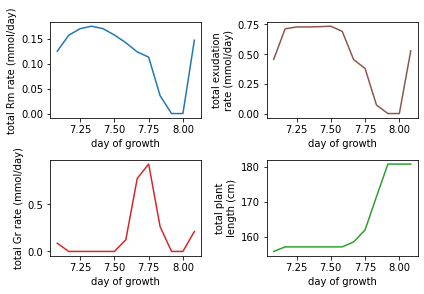

In [8]:
fig, axs = plt.subplots(2,2)
axs[0,0].plot(time, Q_Rmall/dt)
axs[0,0].set(xlabel='day of growth', ylabel='total Rm rate (mmol/day)')
axs[1,0].plot(time, Q_Grall/dt, 'tab:red')
axs[1,0].set(xlabel='day of growth', ylabel='total Gr rate (mmol/day)')
axs[0,1].plot(time, Q_Exudall/dt , 'tab:brown')
axs[0,1].set(xlabel='day of growth', ylabel='total exudation\nrate (mmol/day)')
axs[1,1].plot(time, lengthTotall , 'tab:green')
axs[1,1].set(xlabel='day of growth', ylabel='total plant\nlength (cm)')
fig.tight_layout()
plt.show()

## Take away messages

* Basic idea how to use the class *PhloemFlow*
* The plant growth follows the rate of carbon usage for growth